In [1]:
%matplotlib widget

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import TqdmExperimentalWarning
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import torch
import matplotlib.patches as patches
import math
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib


# neighborSearch, neighborSearchFixed
# from torchCompactRadius.util import volumeToSupport
# from torchCompactRadius.neighborhood import neighborSearch

In [2]:
import torchCompactRadius as tcr
from torchCompactRadius import neighborSearch, neighborSearchExisting, volumeToSupport
# from torchCompactRadius.util import volumeToSupport

computeCapability: 86
smFlag: -gencode=arch=compute_86,code=sm_86
hostFlags: ['-std=c++17', '-fPIC', '-O3', '-DCUDA_VERSION']
cudaFlags: ['-std=c++17', '-O3', '-gencode=arch=compute_86,code=sm_86', '--use_fast_math', '-DCUDA_VERSION']
directory: /home/winchenbach/dev/torchCompactRadius/src/torchCompactRadius
sourceFile: cppSrc/neighborhoodDynamic.cpp
source file exists: cppSrc/neighborhoodDynamic.cpp
sourceFile: cppSrc/neighborhoodDynamic.cu
source file exists: cppSrc/neighborhoodDynamic.cu
sourceFile: cppSrc/neighborhoodFixed.cpp
source file exists: cppSrc/neighborhoodFixed.cpp
sourceFile: cppSrc/neighborhoodFixed.cu
source file exists: cppSrc/neighborhoodFixed.cu
sourceFile: cppSrc/hashing.cpp
source file exists: cppSrc/hashing.cpp
sourceFile: cppSrc/hashing.cu
source file exists: cppSrc/hashing.cu
sourceFile: cppSrc/neighborhoodSmall.cpp
source file exists: cppSrc/neighborhoodSmall.cpp
sourceFile: cppSrc/neighborhoodSmall.cu
source file exists: cppSrc/neighborhoodSmall.cu
sourceFile

Using /home/winchenbach/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Creating extension directory /home/winchenbach/.cache/torch_extensions/py311_cu121/neighborSearch...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/winchenbach/.cache/torch_extensions/py311_cu121/neighborSearch/build.ninja...
Building extension module neighborSearch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/10] c++ -MMD -MF hashing.o.d -DTORCH_EXTENSION_NAME=neighborSearch -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/winchenbach/anaconda3/envs/torch_2_2/lib/python3.11/site-packages/torch/include -isystem /home/winchenbach/anaconda3/envs/torch_2_2/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/winchenbach/anaconda3/envs/torch_2_2/lib/python3.11/site-packages/torch/include/TH -isystem /home/winchenbach/anaconda3/envs/torch_2_2/lib/python3.11/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/winchenbach/anaconda3/envs/torch_2_2/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -std=c++17 -fPIC -O3 -DCUDA_VERSION -c /home/winchenbach/dev/torchCompactRadius/src/torchCompactRadius/cppSrc/hashing.cpp -o hashing.o 
[2/10] c++ -MMD -MF neighborhoodSmall.o.d -DTORCH_EXTENSION_NAME=neighborSearch -DTORCH_API_INCLUDE_

Loading extension module neighborSearch...


In [3]:
import platform
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if platform.system() == 'Darwin':
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cpu')
targetNumNeighbors = 50
hashMapLength = 4096
nx = 32
dim = 2

minDomain = torch.tensor([-1] * dim, dtype = torch.float32, device = device)
maxDomain = torch.tensor([ 1] * dim, dtype = torch.float32, device = device)
maxDomain[0] = 2
periodicity = [True] * dim

extent = maxDomain - minDomain
shortExtent = torch.min(extent, dim = 0)[0].item()
dx = (shortExtent / nx)
ny = int(1 // dx)
h = volumeToSupport(dx**dim, 50, dim)
dy = dx

print("minDomain = ", minDomain)
print("maxDomain = ", maxDomain)
print("extent = ", extent)
print("shortExtent = ", shortExtent)
print("dx = ", dx)
print("nx = ", nx)
print("dy = ", dy)
print("ny = ", ny)
print("h = ", h)
print("periodicity = ", periodicity)
print("device = ", device)
print("targetNumNeighbors = ", targetNumNeighbors)
print("hashMapLength = ", hashMapLength)


minDomain =  tensor([-1., -1.], device='cuda:0')
maxDomain =  tensor([2., 1.], device='cuda:0')
extent =  tensor([3., 2.], device='cuda:0')
shortExtent =  2.0
dx =  0.0625
nx =  32
dy =  0.0625
ny =  16
h =  0.24933892525089543
periodicity =  [True, True]
device =  cuda
targetNumNeighbors =  50
hashMapLength =  4096


In [4]:
positions = []
for d in range(dim):
    positions.append(torch.linspace(minDomain[d] + dx / 2, maxDomain[d] - dx / 2, int((extent[d] - dx) / dx) + 1, device = device))
grid = torch.meshgrid(*positions, indexing = 'xy')
positions = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)
# enable for random positions for alternative debugging
# positions = (torch.rand(nx**dim, dim) * 2 - 1).to(device)

supports = torch.ones(positions.shape[0], device = device) * h

print("positions.shape = ", positions.shape)
print("supports.shape = ", supports.shape)


positions.shape =  torch.Size([1536, 2])
supports.shape =  torch.Size([1536])


In [5]:
ypositions = []
for d in range(dim):
    ypositions.append(torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny, device = device))
grid = torch.meshgrid(*ypositions, indexing = 'xy')
y = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)


# ypos2 = torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny)
# xpos2, ypos2 = torch.meshgrid(xpos2, ypos2, indexing = 'xy')
# y = torch.stack((xpos2.flatten(), ypos2.flatten()), dim = 1).to(device)
# y = torch.clone(positions)
ySupport = torch.ones(y.shape[0], device = device) * supports[0]

print("y.shape = ", y.shape)
print("ySupport.shape = ", ySupport.shape)

y.shape =  torch.Size([256, 2])
ySupport.shape =  torch.Size([256])


In [6]:
from torchCompactRadius.util import hashCellIndices_cpp, linearIndexing, hashCellIndices

# indices = torch.floor((positions - (minDomain).to(positions.device)) / hCell).to(torch.int32)
# linearIndices = linearIndexing(indices, numCells) #indices[:,0] + cellCount[0] * indices[:,1]
# cellIndices, cellCounters = torch.unique_consecutive(linearIndices, return_counts=True, return_inverse=False)

# print('indices', indices)

hashedIndices = hashCellIndices(torch.tensor([[0,0], [1,0], [2,0]]), hashMapLength)
print('hashed indices (python | cpu)', hashedIndices.detach().cpu().numpy())

hashed indices (python | cpu) [   0 1117 2234]


In [7]:
supports

tensor([0.2493, 0.2493, 0.2493,  ..., 0.2493, 0.2493, 0.2493], device='cuda:0')

In [8]:
positions[1] - positions[0]

tensor([0.0625, 0.0000], device='cuda:0')

In [9]:
from torchCompactRadius.cppWrapper import neighborSearchSmall
from torchCompactRadius.util import countUniqueEntries

In [10]:
from torch.masked import masked_tensor, as_masked_tensor
warnings.filterwarnings(action='ignore', category=UserWarning)

In [29]:
from typing import Optional, List
@torch.jit.script
def mod(x, min : float, max : float):
    return torch.where(torch.abs(x) > (max - min) / 2, torch.sgn(x) * ((torch.abs(x) + min) % (max - min) + min), x)
    
@torch.jit.script
def radiusNaive(x, y, hx, hy, periodic : Optional[List[bool]] = None, minDomain = None, maxDomain = None, mode : str = 'gather'):
    periodicity = [False] * x.shape[1] if periodic is None else periodic
    
    pos_x = torch.stack([x[:,i] if not periodic_i else torch.remainder(x[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)
    pos_y = torch.stack([y[:,i] if not periodic_i else torch.remainder(y[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)
    
    distanceMatrices = torch.stack([pos_x[:,i] - pos_y[:,i,None] if not periodic_i else mod(pos_x[:,i] - pos_y[:,i,None], minDomain[i], maxDomain[i]) for i, periodic_i in enumerate(periodicity)], dim = -1)
    distanceMatrix = torch.sqrt(torch.sum(distanceMatrices**2, dim = -1))
    
    indexI, indexJ = torch.meshgrid(torch.arange(x.shape[0]).to(x.device), torch.arange(y.shape[0]).to(y.device), indexing = 'xy')
    if mode == 'gather':        
        gatherMatrix = hx.repeat(hy.shape[0],1)
        adjacencyDense = distanceMatrix <= gatherMatrix
        supports = gatherMatrix[adjacencyDense]
    elif mode == 'scatter':        
        scatterMatrix = hy.repeat(hx.shape[0],1).mT
        adjacencyDense = distanceMatrix <= scatterMatrix
        supports = scatterMatrix[adjacencyDense]
    else:
        symmetricMatrix = (hx + hy[:,None]) / 2
        adjacencyDense = distanceMatrix <= symmetricMatrix
        supports = symmetricMatrix[adjacencyDense]
    
    ii = indexI[adjacencyDense]
    jj = indexJ[adjacencyDense]

    return ii, jj#, distanceMatrix[adjacencyDense], distanceMatrices[adjacencyDense], supports

In [32]:
# for i in range(8):
    # i, j = neighborSearchSmall(y, ySupport, positions, supports, minDomain, maxDomain, periodicTensor, 'symmetric')

nSamples = 1000

starTime = torch.cuda.Event(enable_timing=True)
endTime = torch.cuda.Event(enable_timing=True)
starTime.record()
for i in range(nSamples):
    i, j = radiusNaive(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, 'symmetric')

    # h2 = h**2
    # distanceMat = torch.sum((positions[None,:,:] - y[:,None,:])**2, dim = -1)
    # neighborMat = distanceMat < h2

    # indexI, indexJ = torch.meshgrid(torch.arange(positions.shape[0], device = positions.device), torch.arange(y.shape[0], device = y.device), indexing = 'xy')
    # i = indexI[neighborMat]
    # j = indexJ[neighborMat]

    # ii, ni = countUniqueEntries(i, positions)
    # jj, nj = countUniqueEntries(j, y)

endTime.record()
torch.cuda.synchronize()
print(starTime.elapsed_time(endTime) / nSamples, "ms")


1.51909375 ms


In [20]:
h2 = h**2
distanceMat = torch.sum((positions[None,:,:] - y[:,None,:])**2, dim = -1)
neighborMat = distanceMat < h2

indexI, indexJ = torch.meshgrid(torch.arange(positions.shape[0], device = positions.device), torch.arange(y.shape[0], device = y.device), indexing = 'xy')
i = indexI[neighborMat]
j = indexJ[neighborMat]

ii, ni = countUniqueEntries(i, positions)
jj, nj = countUniqueEntries(j, y)

In [21]:
nj

tensor([45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 

In [ ]:
distanceMatrices = torch.stack([positions[:,i] - y[:,i,None]], dim = -1)
distanceMatrix = torch.sqrt(torch.sum(distanceMatrices**2, dim = -1))

In [14]:
periodicTensor = torch.tensor(periodicity).to(device)
periodicTensor[:] = True

In [15]:
for i in range(8):
    i, j = neighborSearchSmall(y, ySupport, positions, supports, minDomain, maxDomain, periodicTensor, 'symmetric')

nSamples = 1000

starTime = torch.cuda.Event(enable_timing=True)
endTime = torch.cuda.Event(enable_timing=True)
starTime.record()
for i in range(nSamples):
    i, j = neighborSearchSmall(y, ySupport, positions, supports, minDomain, maxDomain, periodicTensor, 'symmetric')

endTime.record()
torch.cuda.synchronize()
print(starTime.elapsed_time(endTime) / nSamples, "ms")




4.3312783203125 ms


In [12]:
print('i', i)
print('j', j)

i tensor([45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45

In [11]:
ii, ni = countUniqueEntries(i, y)
print('ni', ni)
jj, nj = countUniqueEntries(j, positions)
print('nj', nj)

ni tensor([45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 4

In [27]:
(i_cpu, j_cpu), neighborDict = \
     neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'cpp')
# (i_cpu, j_cpu), ni_cpu, nj_cpu = \
     # neighborSearchExisting(y, ySupport, neighborDict, mode = 'symmetric', variant = 'cpp')

In [28]:
def radius(x, y, r, batch_x = None, batch_y = None):
    


SyntaxError: incomplete input (3396646604.py, line 2)

In [ ]:
print(i_cpu)

tensor([  0,   0,   0,  ..., 255, 255, 255], dtype=torch.int32)


In [ ]:
from torchCompactRadius.util import linearIndexing, hashCellIndices
print('i_cpu', i_cpu.device, i_cpu.dtype, i_cpu.shape, i_cpu)
print('j_cpu', j_cpu.device, j_cpu.dtype, j_cpu.shape, j_cpu)
# print('ni_cpu', ni_cpu.device, ni_cpu.dtype, ni_cpu.shape, ni_cpu)
# print('nj_cpu', nj_cpu.device, nj_cpu.dtype, nj_cpu.shape, nj_cpu)
print('sortedPositions', neighborDict['sortedPositions'].device, neighborDict['sortedPositions'].dtype, neighborDict['sortedPositions'].shape, neighborDict['sortedPositions'])
print('sortedSupports', neighborDict['sortedSupports'].device if neighborDict['sortedSupports'] is not None else None, neighborDict['sortedSupports'].dtype if neighborDict['sortedSupports'] is not None else None, neighborDict['sortedSupports'].shape if neighborDict['sortedSupports'] is not None else None, neighborDict['sortedSupports'])
print('hashTable', neighborDict['hashTable'].device, neighborDict['hashTable'].dtype, neighborDict['hashTable'].shape, neighborDict['hashTable'])
print('sortedCellTable', neighborDict['sortedCellTable'].device, neighborDict['sortedCellTable'].dtype, neighborDict['sortedCellTable'].shape, neighborDict['sortedCellTable'])
print('qMin', neighborDict['qMin'].device, neighborDict['qMin'].dtype, neighborDict['qMin'].shape, neighborDict['qMin'])
print('qMax', neighborDict['qMax'].device, neighborDict['qMax'].dtype, neighborDict['qMax'].shape, neighborDict['qMax'])
print('numCells', neighborDict['numCells'].device, neighborDict['numCells'].dtype, neighborDict['numCells'].shape, neighborDict['numCells'])
print('sortIndex', neighborDict['sortIndex'].device, neighborDict['sortIndex'].dtype, neighborDict['sortIndex'].shape, neighborDict['sortIndex'])


# def plotGrid(ax, qMin, qMax, hCell, numCells):
#     ax.add_patch(patches.Rectangle((qMin[0].detach().cpu(), qMin[1].detach().cpu()), (qMax[0] - qMin[0]).detach().cpu(), (qMax[1] - qMin[1]).detach().cpu(), fill=False, edgecolor='b', linewidth = 1))
#     for i in range(numCells[0].detach().cpu() + 1):
#         ax.vlines(x = qMin[0].detach().cpu() + i * hCell, ymin = qMin[1].detach().cpu(), ymax = qMax[1].detach().cpu(), color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
#     for i in range(numCells[1].detach().cpu() + 1): 
#         ax.hlines(y = qMin[1].detach().cpu() + i * hCell, xmin = qMin[0].detach().cpu(), xmax = qMax[0].detach().cpu(), color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
#     ax.set_aspect(1, adjustable='box')

# def scatterPlot(fig, ax, positions, c, scatterSize, title, cmap = 'viridis', norm = 'linear', midPoint = 0):
#     if norm == 'log':
#         dataNorm = matplotlib.colors.LogNorm(vmin = c.min(), vmax = c.max())
#     elif norm == 'sym':
#         dataNorm = matplotlib.colors.Normalize(vmin = midPoint - (midPoint - c).abs().max(), vmax = midPoint + (midPoint - c).abs().max())
#     else:
#         dataNorm = matplotlib.colors.Normalize(vmin = c.min(), vmax = c.max())

#     sc = ax.scatter(positions[:,0].detach().cpu(), positions[:,1].detach().cpu(), c = c.detach().cpu(), s = scatterSize, label = title, cmap = cmap, norm = dataNorm)
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)    
#     plt.colorbar(sc, cax=cax)
#     ax.set_title(title)
    
# if dim == 1:
#     fig, axis = plt.subplots(1,2, figsize=(8,4), sharex = True, sharey = True, squeeze = False)

#     axis[0,0].scatter(positions[:,0].cpu(), nj_cpu.cpu(), s = 1, c = 'r')
#     axis[0,0].scatter(y[:,0].cpu(), ni_cpu.cpu(), s = 1, c = 'b')
# elif dim > 1:
#     fig, axis = plt.subplots(2, 4, figsize=(12,4), sharex = True, sharey = True, squeeze = False)

#     for ax in axis.flatten():
#         plotGrid(ax, neighborDict['qMin'] , neighborDict['qMax'], neighborDict['hCell'], neighborDict['numCells'])
#     scatterSize = 100 / math.sqrt(positions.shape[0])

#     scatterPlot(fig, axis[0,0], positions, positions.new_ones(positions.shape[0]) * h if supports is None else supports, scatterSize, 'Reference Particles [x]')
#     scatterPlot(fig, axis[0,1], neighborDict['sortedPositions'], positions.new_ones(positions.shape[0]) * h if neighborDict['sortedSupports'] is None else neighborDict['sortedSupports'], scatterSize, 'Sorted Reference Positions [x]')
#     scatterPlot(fig, axis[1,0], y, ySupport, scatterSize, 'Query Particles [y]')

#     scatterPlot(fig, axis[0,2], positions, neighborDict['sortIndex'], scatterSize, 'Sort Index [x]', cmap = 'tab20', norm = 'linear')


#     cellIndices = torch.floor((y - neighborDict['qMin']) / neighborDict['hCell']).to(torch.int32)
#     linearIndices = linearIndexing(cellIndices, neighborDict['numCells'])
#     hashIndices = hashCellIndices(cellIndices, hashMapLength)
#     scatterPlot(fig, axis[1,1], y, linearIndices, scatterSize, 'Linear Indices [y]', cmap = 'tab20', norm = 'linear')
#     scatterPlot(fig, axis[1,2], y, hashIndices, scatterSize, 'Hash Indices [y]', cmap = 'tab20', norm = 'linear')

#     scatterPlot(fig, axis[0,3], positions, nj_cpu, scatterSize, 'Num Neighbors [x]')
#     scatterPlot(fig, axis[1,3], y, ni_cpu, scatterSize, 'Num Neighbors [y]')

#     fig.tight_layout()
    

i_cpu cpu torch.int64 torch.Size([11520]) tensor([  0,   0,   0,  ..., 255, 255, 255])
j_cpu cpu torch.int64 torch.Size([11520]) tensor([ 246,  293,  294,  ..., 1225, 1226, 1273])
sortedPositions cpu torch.float32 torch.Size([1536, 2]) tensor([[-0.9062, -0.9688],
        [-0.7812, -0.9062],
        [-0.8438, -0.9062],
        ...,
        [ 1.8438,  0.7812],
        [ 1.9062,  0.7812],
        [ 1.9688,  0.7812]])
sortedSupports cpu torch.float32 torch.Size([1536]) tensor([0.2493, 0.2493, 0.2493,  ..., 0.2493, 0.2493, 0.2493])
hashTable cpu torch.int32 torch.Size([4096, 2]) tensor([[ 0,  1],
        [-1,  0],
        [-1,  0],
        ...,
        [-1,  0],
        [-1,  0],
        [95,  1]], dtype=torch.int32)
sortedCellTable cpu torch.int32 torch.Size([96, 3]) tensor([[   0,    0,   16],
        [  63, 1008,   16],
        [  43,  688,   16],
        [  23,  368,   16],
        [  12,  192,   16],
        [  75, 1200,   16],
        [  55,  880,   16],
        [  35,  560,   16],
  

In [ ]:
import platform

def generateNeighborTestData(nx, targetNumNeighbors, dim, maxDomain_0, periodic, device):


    minDomain = torch.tensor([-1] * dim, dtype = torch.float32, device = device)
    maxDomain = torch.tensor([ 1] * dim, dtype = torch.float32, device = device)
    maxDomain[0] = maxDomain_0
    periodicity = [periodic] * dim

    extent = maxDomain - minDomain
    shortExtent = torch.min(extent, dim = 0)[0].item()
    dx = (shortExtent / nx)
    ny = int(1 // dx)
    h = volumeToSupport(dx**dim, targetNumNeighbors, dim)
    dy = dx

    # print("minDomain = ", minDomain)
    # print("maxDomain = ", maxDomain)
    # print("extent = ", extent)
    # print("shortExtent = ", shortExtent)
    # print("dx = ", dx)
    # print("nx = ", nx)
    # print("dy = ", dy)
    # print("ny = ", ny)
    # print("h = ", h)
    # print("periodicity = ", periodicity)
    # print("device = ", device)
    # print("targetNumNeighbors = ", targetNumNeighbors)
    # print("hashMapLength = ", hashMapLength)
    positions = []
    for d in range(dim):
        positions.append(torch.linspace(minDomain[d] + dx / 2, maxDomain[d] - dx / 2, int((extent[d] - dx) / dx) + 1, device = device))
    grid = torch.meshgrid(*positions, indexing = 'xy')
    positions = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)
    # enable for random positions for alternative debugging
    # positions = (torch.rand(nx**dim, dim) * 2 - 1).to(device)

    supports = torch.ones(positions.shape[0], device = device) * h

    # print("positions.shape = ", positions.shape)
    # print("supports.shape = ", supports.shape)
    ypositions = []
    for d in range(dim):
        ypositions.append(torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny, device = device))
    grid = torch.meshgrid(*ypositions, indexing = 'xy')
    y = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)


    # ypos2 = torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny)
    # xpos2, ypos2 = torch.meshgrid(xpos2, ypos2, indexing = 'xy')
    # y = torch.stack((xpos2.flatten(), ypos2.flatten()), dim = 1).to(device)
    # y = torch.clone(positions)
    ySupport = torch.ones(y.shape[0], device = device) * supports[0]

    # print("y.shape = ", y.shape)
    # print("ySupport.shape = ", ySupport.shape)

    return (y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, positions.shape[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if platform.system() == 'Darwin':
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')
targetNumNeighbors = 50
hashMapLength = 4096
nx = 32
dim = 3
periodic = True

(y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength = generateNeighborTestData(nx, targetNumNeighbors, dim, 1.0, periodic, device)

(i_cpu, j_cpu), ni_cpu, nj_cpu, neighborDict = \
    neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'scatter', 'cpp')
# return ni_cpu, nj_cpu

In [ ]:
import pandas as pd
import time
from tqdm.autonotebook import tqdm

In [ ]:

dataset = pd.DataFrame()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if platform.system() == 'Darwin':
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cpu')
targetNumNeighbors = 50


ptcls = np.logspace(8, 22, 64, base = 2).astype(int)
dims = [1,2,3]
periodics = [16, 32, 64, 256]
iters = 8

t_nx = tqdm(ptcls)
t_dim = tqdm(dims)
t_periodic = tqdm(periodics)
t_iter = tqdm(range(iters))

t_nx.reset()
for ptcl in ptcls:
    t_nx.set_description("ptcls = %d" % ptcl)
    t_dim.reset()
    for dim in dims:
        nx = int(ptcl ** (1 / dim))
        t_dim.set_description("dim = %d, nx = %d" % (dim, nx))
        t_periodic.reset()
        for periodic in periodics:
            t_periodic.set_description("numNeighbors = %d" % periodic)
            (y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength = generateNeighborTestData(nx, periodic, dim, 1.0, False, device)
            # print(y.shape, positions.shape, ySupport.shape, supports.shape, minDomain, maxDomain, periodicity, hashMapLength)
            # (i_cpu, j_cpu), ni_cpu, nj_cpu , neighborDict = neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'scatter', 'cpp')
            t_iter.reset()
            for i in range(iters):
                t_iter.set_description("i = %d" % i)
                start_time = time.time()
                # for i in range(8):
                (i_cpu, j_cpu), ni_cpu, nj_cpu , neighborDict = neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'scatter', 'cpp')
                end_time = time.time()
                torch.cuda.empty_cache()        

                df = pd.DataFrame({
                    'ptcls': nx**dim, 'nx': nx, 'dim': dim, 'targetNumNeighbors': periodic, 
                    'time': end_time - start_time, 'device': device.type, 
                    # 'ni_cpu.min()': ni_cpu.min().item(), 'ni_cpu.max()': ni_cpu.max().item(), 'nj_cpu.min()': nj_cpu.min().item(), 'nj_cpu.max()': nj_cpu.max().item()
                    }, index = [0])
                if i > 0:
                    dataset = pd.concat([dataset, df], ignore_index = True)
                t_iter.update()
            t_periodic.update()
        t_dim.update()
    t_nx.update()
            # print(ni_cpu, nj_cpu)
                

            # print('nx', nx, 'dim', dim, 'periodic', periodic, 'ni_cpu.min()', ni_cpu.min(), 'ni_cpu.max()', ni_cpu.max(), 'nj_cpu.min()', nj_cpu.min(), 'nj_cpu.max()', nj_cpu.max())

            # print(f'ni_cpu.shape = {ni_cpu.shape}, nj_cpu.shape = {nj_cpu.shape}, ni_cpu.min() = {ni_cpu.min()}, ni_cpu.max() = {ni_cpu.max()}, nj_cpu.min() = {nj_cpu.min()}, {nj_cpu.max()}')
    # ni_cpu, nj_cpu = generateNeighborTestData(nx, targetNumNeighbors, dim, 1.0, periodic, device)
    # print(f'ni_cpu.shape = {ni_cpu.shape}, nj_cpu.shape = {nj_cpu.shape}, ni_cpu.min() = {ni_cpu.min()}, ni_cpu.max() = {ni_cpu.max()}, nj_cpu.min() = {nj_cpu.min()}, nj_cpu.max() = {nj_cpu.max()}')

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import copy
from scipy.optimize import curve_fit

In [ ]:
data = copy.deepcopy(dataset)

def func(x, a, b):
    return a * x**b
# Extract the data from the dataset
# x = data[data['device'] == 'cpu']['ptcls']
# y = data[data['device'] == 'cpu']['time']
# popt, pcov = curve_fit(func, x, y)
# a_fit = popt[0]
# b_fit = popt[1]
# print('a:', a_fit, 'b:', b_fit)

x = data[data['device'] == 'cuda']['ptcls']
y = data[data['device'] == 'cuda']['time']
popt, pcov = curve_fit(func, x, y)
a_fit = popt[0]
b_fit = popt[1]
print('a:', a_fit, 'b:', b_fit)

a: 0.025282465343161253 b: 0.05603407068706623


In [ ]:
data = copy.deepcopy(dataset)

def func(x, a, b):
    return a * x**b
# Extract the data from the dataset
# x = data[data['device'] == 'cpu']['ptcls']
# y = data[data['device'] == 'cpu']['time']
# popt, pcov = curve_fit(func, x, y)
# a_fit = popt[0]
# b_fit = popt[1]
# print('a:', a_fit, 'b:', b_fit)

x = data[data['device'] == 'cuda']['ptcls']
y = data[data['device'] == 'cuda']['time']
popt, pcov = curve_fit(func, x, y)
a_fit = popt[0]
b_fit = popt[1]
print('a:', a_fit, 'b:', b_fit)

a: 0.00037147108727116806 b: 0.28183584278908663


In [ ]:
import seaborn as sns

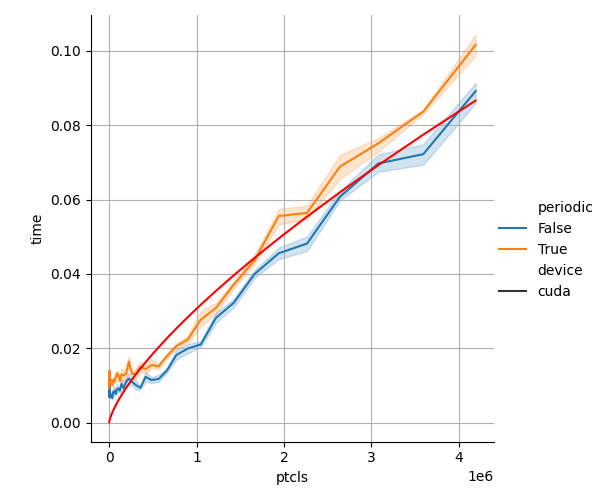

In [ ]:
data = copy.deepcopy(dataset)
data['dim'] = data['dim'].astype('category')
data['periodic'] = data['periodic'].astype('category')
g = sns.relplot(data = data, x = 'ptcls', y = 'time', hue = 'periodic', style = 'device', kind = 'line')

# g.set(xscale = 'log')
# g.set(yscale = 'log')

g.ax.plot(x, func(x, *popt), 'r-', label = f'fit: a={a_fit:.2f}, b={b_fit:.2f}')
data = copy.deepcopy(dataset)
# data['dim'] = data['dim'].astype('category')
# data['periodic'] = data['periodic'].astype('category')
# g = sns.relplot(data=data, x='ptcls', y='time', hue='periodic', style='device')

# g.ax.plot(x, func(x, *popt), 'r-', label=f'fit: a={a_fit:.2f}, b={b_fit:.2f}')
g.ax.grid(True, which = 'both')  # Add grid to the plot


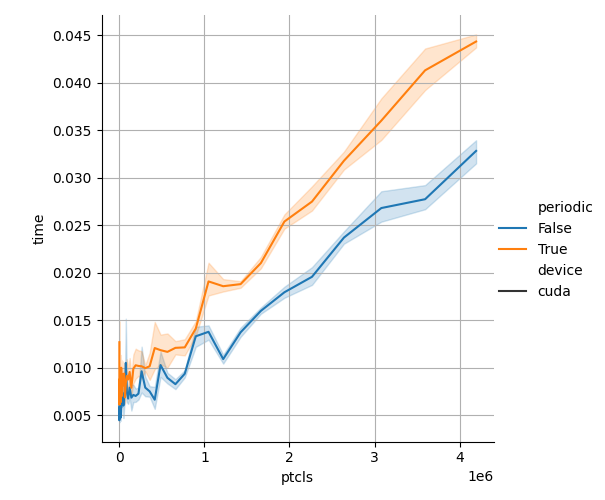

In [ ]:
data = copy.deepcopy(dataset)
data['dim'] = data['dim'].astype('category')
data['periodic'] = data['periodic'].astype('category')
g = sns.relplot(data = data, x = 'ptcls', y = 'time', hue = 'periodic', style = 'device', kind = 'line')

# g.set(xscale = 'log')
# g.set(yscale = 'log')

# g.ax.plot(x, func(x, *popt), 'r-', label = f'fit: a={a_fit:.2f}, b={b_fit:.2f}')
data = copy.deepcopy(dataset)
# data['dim'] = data['dim'].astype('category')
# data['periodic'] = data['periodic'].astype('category')
# g = sns.relplot(data=data, x='ptcls', y='time', hue='periodic', style='device')

# g.ax.plot(x, func(x, *popt), 'r-', label=f'fit: a={a_fit:.2f}, b={b_fit:.2f}')
g.ax.grid(True, which = 'both')  # Add grid to the plot


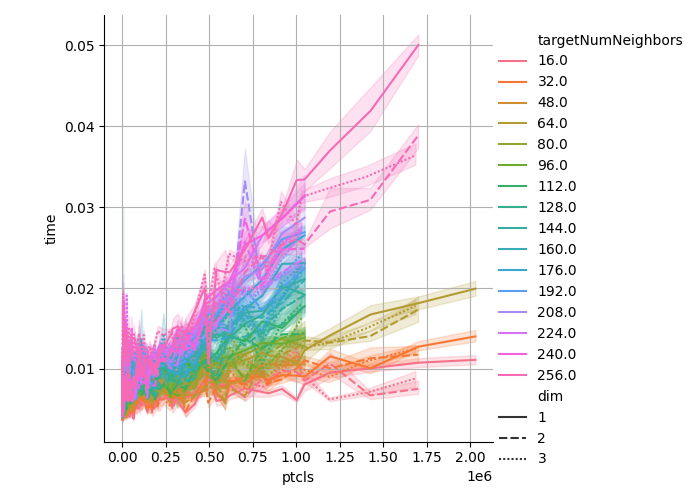

In [ ]:
data = copy.deepcopy(dataset)
data = data[data['ptcls'] > 512]
data['dim'] = data['dim'].astype('category')
data['targetNumNeighbors'] = data['targetNumNeighbors'].astype('category')

g = sns.relplot(data = data, x = 'ptcls', y = 'time', hue = 'targetNumNeighbors', style = 'dim', kind = 'line')

# g.set(xscale = 'log')
# g.set(yscale = 'log')

# g.ax.plot(x, func(x, *popt), 'r-', label = f'fit: a={a_fit:.2f}, b={b_fit:.2f}')
data = copy.deepcopy(dataset)
# data['dim'] = data['dim'].astype('category')
# data['periodic'] = data['periodic'].astype('category')
# g = sns.relplot(data=data, x='ptcls', y='time', hue='periodic', style='device')

# g.ax.plot(x, func(x, *popt), 'r-', label=f'fit: a={a_fit:.2f}, b={b_fit:.2f}')
g.ax.grid(True, which = 'both')  # Add grid to the plot


In [ ]:
(y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength = generateNeighborTestData(nx, targetNumNeighbors, dim, 1.0, periodic, device)

(i_cpu, j_cpu), ni_cpu, nj_cpu , neighborDict = neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'scatter', 'cpp')
periodicity = [False] * dim

In [ ]:
import torch.autograd.profiler as profiler

with profiler.profile(record_shapes=False, use_cuda=torch.cuda.is_available()) as prof:
    for i in range(32):
        with profiler.record_function("neighborSearch"):
            (i_cpu, j_cpu), ni_cpu, nj_cpu, neighborDict = neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'scatter', 'cpp')

print(prof.key_averages().table(sort_by="cpu_time_total"))

# Export the trace
prof.export_chrome_trace("trace.json")


STAGE:2024-02-12 21:04:43 31126:31126 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2024-02-12 21:04:45 31126:31126 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2024-02-12 21:04:45 31126:31126 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         neighborSearch         0.69%       7.645ms       100.00%        1.108s      34.620ms       1.758ms         0.16%        1.123s      35.084ms            32  
                neighborSearch - sortReferenceParticles         4.45%      49.297ms        76.90%     851.933ms      13.311ms      23.855ms         2.12%     407.857ms       6.373ms            64  
         